In [1]:
# Code partially adapted from
# Citation
# https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3

In [3]:
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
from constants import macroWords, sectorWords, tickerList, companies
import warnings
import sys
tickerDict = {v: k for k, v in companies.items()}
plt.style.use('seaborn-whitegrid')

In [96]:
df_col = df['adjclose']
df_col

date
2006-10-20    49.423508
2006-10-23    49.358711
2006-10-24    49.315510
2006-10-25    49.286705
2006-10-26    49.704327
                ...    
2013-11-15    64.426941
2013-11-18    64.572685
2013-11-19    64.735603
2013-11-20    64.478386
2013-11-21    65.447258
Name: adjclose, Length: 1785, dtype: float64

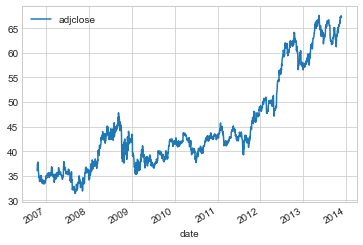

In [4]:
# Import dataframe
df = pd.read_csv('Data/stocks_dateRange/wmt.csv', parse_dates=['date'], index_col=['date'])
df.plot(y='adjclose', use_index=True)
df_adjClose = df.drop(['open', 'high', 'low', 'close', 'volume'], axis=1, inplace = False)

In [4]:
def get_stationarity(series):
    rolling_mean = series.rolling(window=12).mean()
    rolling_std = series.rolling(window=12).std()

    plt.plot(series, color='blue', label='Original')
    plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
    plt.plot(rolling_std, color = 'black', label ='Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean and Rolling Standard Deviation')
    plt.show(block=False)
    
    # Dickey-Fuller test
    result = adfuller(series, autolag = 'AIC')
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}:{}'.format(key, value))

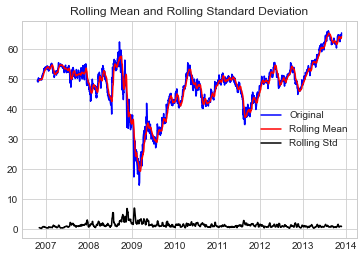

ADF Statistic: -1.6737866386838993
p-value: 0.4446664655620391
Critical Values:
	1%:-3.4340332205127657
	5%:-2.8631669370039785
	10%:-2.567636130407771


In [5]:
get_stationarity(df_adjClose)

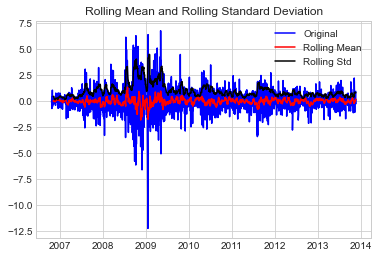

ADF Statistic: -20.18250696808855
p-value: 0.0
Critical Values:
	1%:-3.4340332205127657
	5%:-2.8631669370039785
	10%:-2.567636130407771


In [6]:
# First order differencing
df_shift = df_adjClose - df_adjClose.shift()
df_shift.dropna(inplace=True)
get_stationarity(df_shift)

In [6]:
df_test.index[0]

Timestamp('2012-06-22 00:00:00')

In [5]:
# Test train split here
df_train = df_adjClose[0:int(0.8*df_adjClose.shape[0])]
df_test = df_adjClose[int(0.8*df_adjClose.shape[0]):]

In [8]:
p = q = d = range(0, 2)
pdq = list(itertools.product(p, d, q))

period = [5, 10, 20, 40]
pdqs = list(itertools.product(p, d, q, period))


In [9]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
min_aic = sys.float_info.max
for param in pdq:
    for param_seasonal in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=True,
                                            enforce_invertibility=False)

            results = mod.fit()
            if (results.aic < min_aic):
                min_aic = results.aic
                best = (param, param_seasonal)
        except:
            continue
            
print('ARIMA{}x{} - AIC:{}'.format(best[0], best[1], results.aic))

mod = sm.tsa.statespace.SARIMAX(df_train,
                                order=best[0],
                                seasonal_order=best[1],
                                enforce_stationarity=True,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary())

ARIMA(1, 1, 1)x(1, 1, 1, 20) - AIC:4804.4726925518125
                                     SARIMAX Results                                      
Dep. Variable:                           adjclose   No. Observations:                 1428
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 20)   Log Likelihood               -2397.236
Date:                            Wed, 06 May 2020   AIC                           4804.473
Time:                                    13:56:23   BIC                           4830.719
Sample:                                         0   HQIC                          4814.282
                                           - 1428                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5755      0.082      7.043      0.000      

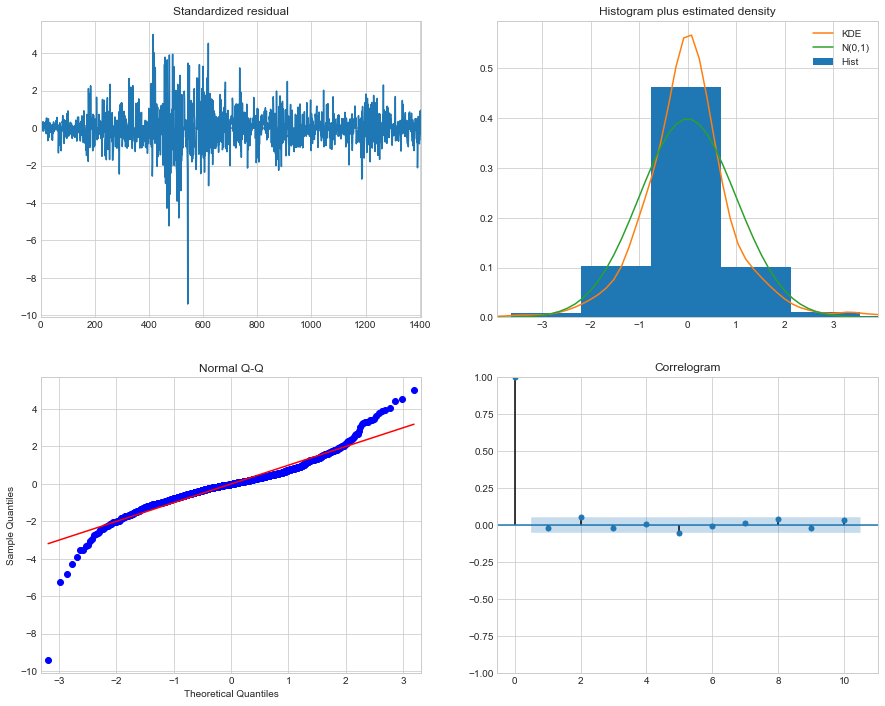

In [10]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [65]:
pred = results.get_prediction(start=pd.to_datetime('2007-02-01'), dynamic=False)
pred_ci = pred.conf_int()

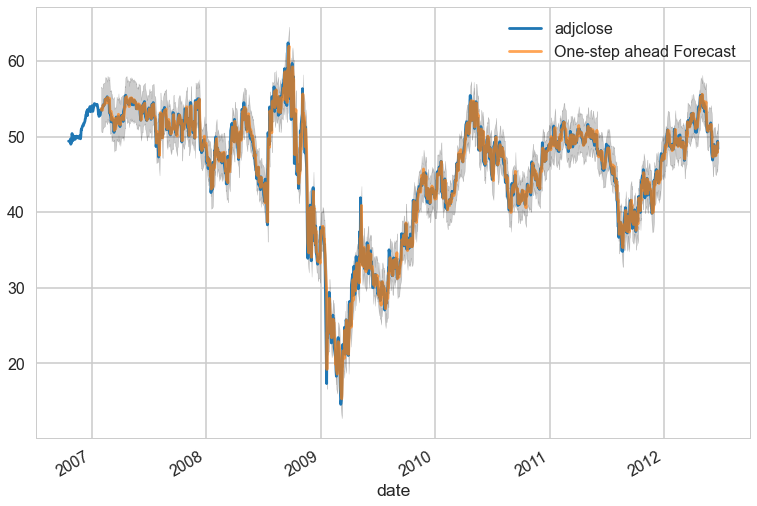

In [41]:
plt.style.use('seaborn-poster')
ax = df_train.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
             pred_ci.iloc[:, 0],
             pred_ci.iloc[:, 1], color='k', alpha=.2)
plt.legend()
plt.show()

In [89]:
print(results.params)
print(test_results.params)

ar.L1       0.575519
ma.L1      -0.693635
ar.S.L20    0.038696
ma.S.L20   -1.000011
sigma2      1.665428
dtype: float64
ar.L1       0.575519
ma.L1      -0.693635
ar.S.L20    0.038696
ma.S.L20   -1.000011
sigma2      1.665428
dtype: float64


In [66]:
y_forecasted = pred.predicted_mean
y_truth = df_train['2007-02-01':]['adjclose']

# Compute the mean square error (train)
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 1.79


In [98]:
df_test.index[0]

Timestamp('2012-06-22 00:00:00')

In [81]:
test_results  = results.apply(df_adjClose)
pred = test_results.get_prediction(start=pd.to_datetime('2012-06-22'), dynamic=False)
pred_ci = pred.conf_int()


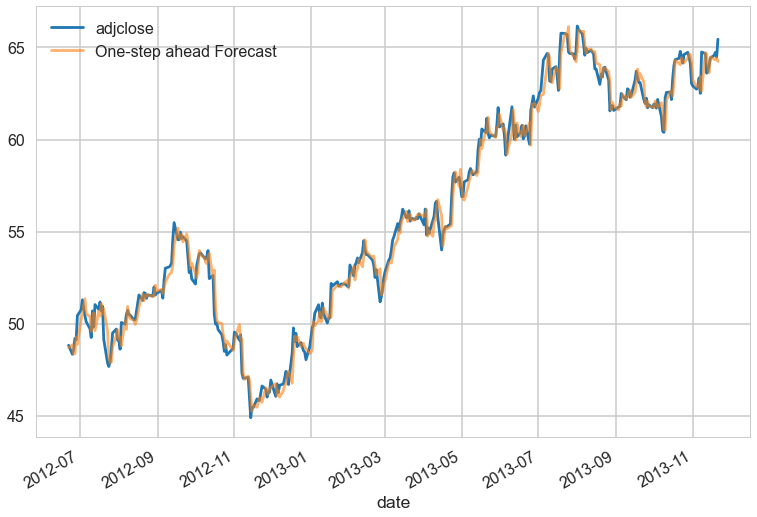

In [94]:
plt.style.use('seaborn-poster')
ax = df_test.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.6)
plt.legend()
plt.show()

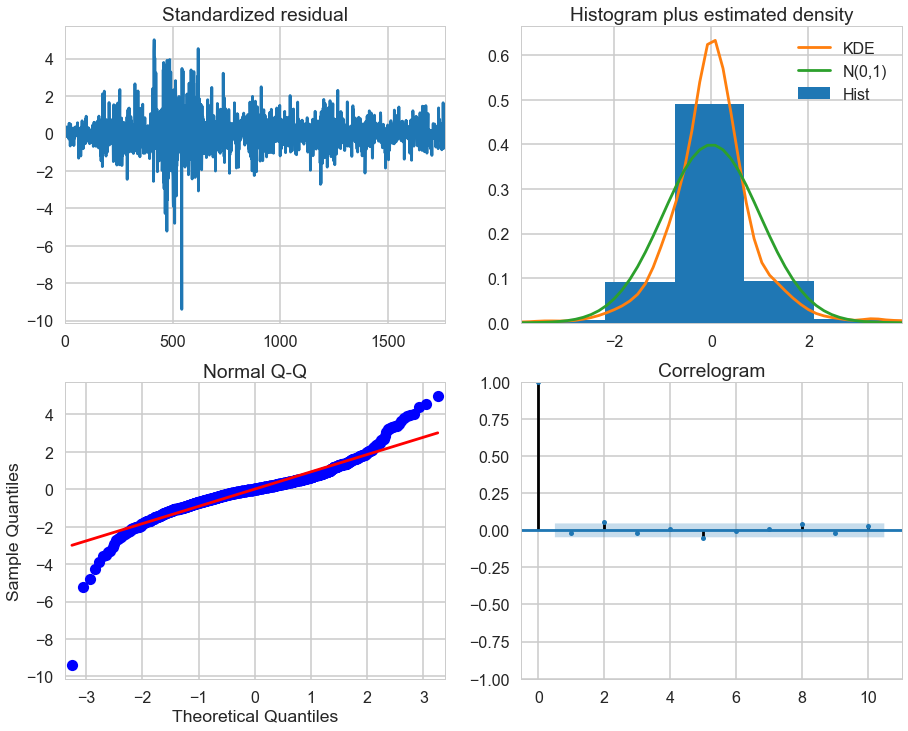

In [91]:
test_results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [85]:
y_forecasted = pred.predicted_mean
y_truth = df_test['2012-06-22':]['adjclose']

# Compute the mean square error (train)
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.45
